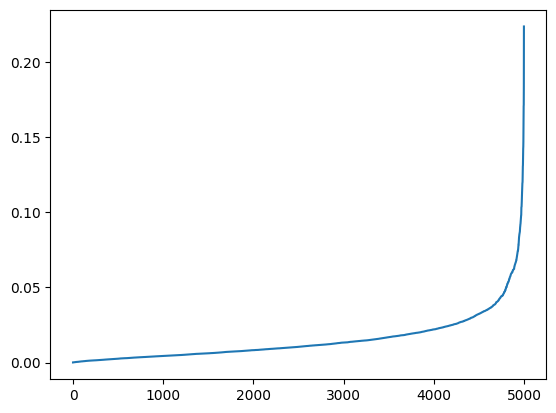

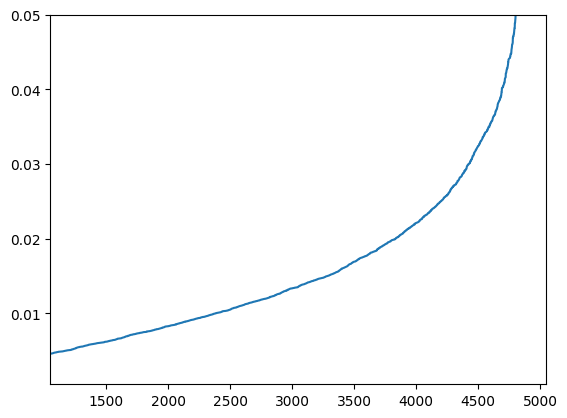

Predicted Distribution:  Counter({2: 1323, 0: 978, 8: 684, 5: 670, 7: 336, 6: 331, 4: 323, 3: 312, -1: 33, 10: 4, 1: 3, 9: 3})
Counter({13: 350, 14: 350, 15: 350, 12: 349, 11: 347, 10: 342, 9: 341, 8: 338, 7: 334, 6: 326, 5: 325, 4: 318, 2: 316, 3: 314, 1: 300})


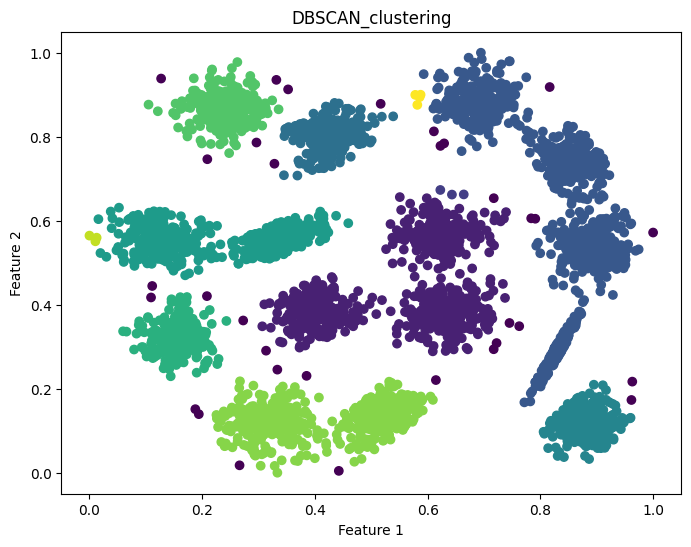

Confusion Matrix:


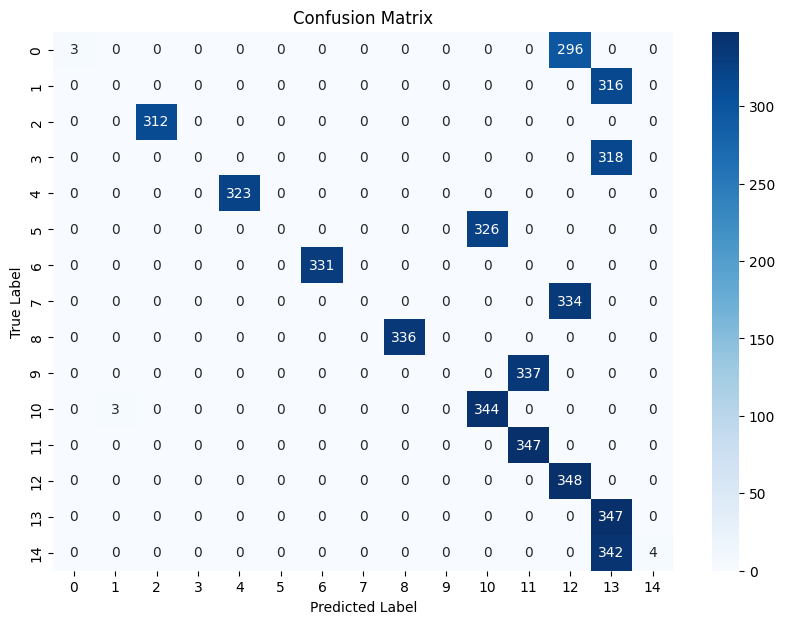


Overall Accuracy: 53.90%
This represents the proportion of all data points that were correctly grouped by the clustering algorithm.
Timestamp: 2024-02-12 16:38:56.699659
Dataset: s1
Clustering Algorithm: DBSCAN_clustering
Algorithm Details: {'algorithm': 'auto', 'eps': 0.0293, 'leaf_size': 30, 'metric': 'euclidean', 'metric_params': None, 'min_samples': 3, 'n_jobs': None, 'p': None}
Running Time (seconds): 0.024999618530273438
Accuracy: 0.539


In [7]:
from collections import Counter
from sklearn.cluster import DBSCAN
import pandas as pd
from src.utils_clustering import *
import time

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

N_CLASSES = 15
DATASET_FILE_NAME = "s1"
file_path = rf'..\data\processed\{DATASET_FILE_NAME}.txt'
processed_data = pd.read_csv(file_path)
# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(processed_data)

# Determine the optimal eps using the k-distance graph
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(scaled_data)
distances, indices = neighbors_fit.kneighbors(scaled_data)
distances = np.sort(distances, axis=0)
distances = distances[:, 1]
plt.plot(distances)

plt.show()
# Scale the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(processed_data)

# Determine the optimal eps using the k-distance graph
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(scaled_data)
distances, indices = neighbors_fit.kneighbors(scaled_data)
distances = np.sort(distances, axis=0)
distances = distances[:, 1]
plt.plot(distances)

plt.xlim(1050, 5050)  # Limit to the first 1000 points for x-axis
plt.ylim(0.0005, 0.05)  # Adjust the y-axis to the range of interest
plt.show()
# Start measuring time
start_time = time.time()

dbscan_clustering = DBSCAN(eps=0.0293, min_samples=3)
labels_pred = dbscan_clustering.fit_predict(processed_data)

# Measure elapsed time
end_time = time.time()
running_time = end_time - start_time
running_time_in_seconds = running_time / 60
running_time_in_seconds
cluster_distribution = Counter(labels_pred)
print("Predicted Distribution: ", cluster_distribution)
LABELS_FILE_NAME = 's1-label'
labels_true = load_labels_from_file(rf'..\data\label\{LABELS_FILE_NAME}.pa', len(labels_pred))
cluster_distribution = Counter(labels_true)
print(cluster_distribution)
clustering_algorithm_name = 'DBSCAN_clustering'
dataset_name = DATASET_FILE_NAME
results_path = r'../results/metrics/results.csv'
plot_clusters(processed_data, labels_pred, title=clustering_algorithm_name)
labels_pred = map_clusters_to_ground_truth_dbscan(labels_true, labels_pred)

generate_confusion_matrix(labels_true, labels_pred, N_CLASSES)
algorithm_params = dbscan_clustering.get_params()
algorithm_details = str(algorithm_params)
# Evaluate and save results
evaluate_clustering(X=processed_data, labels_true=labels_true, labels_pred=labels_pred,
                    clus_algo_name=clustering_algorithm_name, dataset_name=dataset_name,
                    results_path=results_path, algorithm_details=algorithm_details,
                    running_time=running_time)

In [8]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import numpy as np

# Assuming scaled_data is already prepared from your script

def evaluate_dbscan_params(data, eps_values, min_samples_values):
    results = []
    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(data)
            if len(np.unique(labels)) > 1:  # More than 1 cluster, excluding noise
                silhouette = silhouette_score(data, labels)
                davies_bouldin = davies_bouldin_score(data, labels)
                try:
                    calinski_harabasz = calinski_harabasz_score(data, labels)
                except ValueError:
                    calinski_harabasz = None  # Can't be computed if only one cluster is found
                results.append((eps, min_samples, silhouette, davies_bouldin, calinski_harabasz))
            else:
                print(f"Skipping (eps: {eps}, min_samples: {min_samples}) due to a single cluster.")
    return pd.DataFrame(results, columns=['eps', 'min_samples', 'silhouette', 'davies_bouldin', 'calinski_harabasz'])

# Define your ranges for eps and min_samples based on prior analysis
eps_values = np.arange(0.09, 0.1, 0.01)  # Example range, adjust based on k-distance graph
min_samples_values = range(3, 4)  # Example range

# Evaluate DBSCAN across parameter ranges
dbscan_results = evaluate_dbscan_params(scaled_data, eps_values, min_samples_values)

# Save or print your results for further analysis
print(dbscan_results)

# Optionally, find the parameter combination with the best (highest or lowest) score
best_params = dbscan_results.loc[dbscan_results['silhouette'].idxmax()]  # Example for silhouette
print("Best parameters based on Silhouette Score:", best_params)


    eps  min_samples  silhouette  davies_bouldin  calinski_harabasz
0  0.09            3    0.352589        1.296988        2980.716378
1  0.10            3    0.291813        1.577479        2138.772075
Best parameters based on Silhouette Score: eps                     0.090000
min_samples             3.000000
silhouette              0.352589
davies_bouldin          1.296988
calinski_harabasz    2980.716378
Name: 0, dtype: float64


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import os
import warnings

warnings.filterwarnings("ignore")

# Configuration
DATA_FILE_PATH = '../data/processed/s1.txt'  # Update this path
RESULTS_PATH = '../results/metrics'  # Ensure this directory exists
if not os.path.exists(RESULTS_PATH):
    os.makedirs(RESULTS_PATH)
    
def plot_dbscan_metrics(results_df, metric_name, results_path):
    plt.figure(figsize=(10, 6))
    min_samples_values = results_df['min_samples'].unique()
    for min_samples in min_samples_values:
        subset = results_df[results_df['min_samples'] == min_samples]
        plt.plot(subset['eps'], subset[metric_name], marker='o', linestyle='-', label=f'min_samples={min_samples}')
    
    plt.title(f'DBSCAN {metric_name} by eps for different min_samples')
    plt.xlabel('eps')
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(results_path, f'{metric_name.replace(" ", "_")}_by_eps.png'))
    plt.show()

# Load and preprocess data
def load_and_preprocess_data(filepath):
    data = pd.read_csv(filepath, header=None, skiprows=1)  # Update if your data has a header
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    return data_scaled

# Evaluate DBSCAN parameters
def evaluate_dbscan_params(data, eps_values, min_samples_values):
    results = []
    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(data)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # Excluding noise if present
            if n_clusters > 1:  # More than 1 cluster, excluding noise
                silhouette = silhouette_score(data, labels)
                davies_bouldin = davies_bouldin_score(data, labels)
                try:
                    calinski_harabasz = calinski_harabasz_score(data, labels)
                except ValueError:
                    calinski_harabasz = None  # Can't be computed if only one cluster is found
                results.append((eps, min_samples, silhouette, davies_bouldin, calinski_harabasz, n_clusters))
            else:
                print(f"Skipping (eps: {eps}, min_samples: {min_samples}) due to a single cluster.")
    return pd.DataFrame(results, columns=['eps', 'min_samples', 'silhouette', 'davies_bouldin', 'calinski_harabasz', 'n_clusters'])

# if __name__ == "__main__":
#     # Load and scale data
#     scaled_data = load_and_preprocess_data(DATA_FILE_PATH)
#     
#     # Define your ranges for eps and min_samples based on prior analysis
#     eps_values = np.arange(0.01, 0.2, 0.005)  # Adjust based on your dataset
#     min_samples_values = range(2, 31)  # Adjust based on your dataset
# 
#     # Evaluate DBSCAN across parameter ranges
#     dbscan_results = evaluate_dbscan_params(scaled_data, eps_values, min_samples_values)
# 
#     # Save the results for further analysis
#     results_file_path = os.path.join(RESULTS_PATH, 'dbscan_tuning_results.csv')
#     dbscan_results.to_csv(results_file_path, index=False)
#     print(f"Results saved to {results_file_path}")
#     
#     # Print best parameters based on Silhouette Score
#     best_params = dbscan_results.loc[dbscan_results['silhouette'].idxmax()]
#     print("Best parameters based on Silhouette Score:", best_params)
#     
#     # Plotting metrics
#     for metric in ['silhouette', 'davies_bouldin', 'calinski_harabasz']:
#         if metric in dbscan_results.columns:  # Check if metric was computed
#             plot_dbscan_metrics(dbscan_results, metric, RESULTS_PATH)


In [10]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import os
import warnings

warnings.filterwarnings("ignore")

# Configuration
DATA_FILE_PATH = '../data/processed/s1.txt'  # Update this path
RESULTS_PATH = '../results/metrics'  # Ensure this directory exists
if not os.path.exists(RESULTS_PATH):
    os.makedirs(RESULTS_PATH)
    

# Load and preprocess data
def load_and_preprocess_data(filepath):
    data = pd.read_csv(filepath, header=None, skiprows=1)  # Update if your data has a header
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    return data_scaled

# Evaluate DBSCAN parameters
def evaluate_dbscan_params(data, eps_values, min_samples_values):
    results = []
    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(data)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # Excluding noise if present
            if n_clusters > 1:  # More than 1 cluster, excluding noise
                silhouette = silhouette_score(data, labels)
                davies_bouldin = davies_bouldin_score(data, labels)
                try:
                    calinski_harabasz = calinski_harabasz_score(data, labels)
                except ValueError:
                    calinski_harabasz = None  # Can't be computed if only one cluster is found
                results.append((eps, min_samples, silhouette, davies_bouldin, calinski_harabasz, n_clusters))
            else:
                print(f"Skipping (eps: {eps}, min_samples: {min_samples}) due to a single cluster.")
    return pd.DataFrame(results, columns=['eps', 'min_samples', 'silhouette', 'davies_bouldin', 'calinski_harabasz', 'n_clusters'])

# if __name__ == "__main__":
#     # Load and scale data
#     scaled_data = load_and_preprocess_data(DATA_FILE_PATH)
#     
#     # Define your ranges for eps and min_samples based on prior analysis
#     eps_values = np.arange(0.02, 0.03, 0.005)  # Adjust based on your dataset
#     min_samples_values = range(2, 31)  # Adjust based on your dataset
# 
#     # Evaluate DBSCAN across parameter ranges
#     dbscan_results = evaluate_dbscan_params(scaled_data, eps_values, min_samples_values)
# 
#     # Save the results for further analysis
#     results_file_path = os.path.join(RESULTS_PATH, 'dbscan_tuning_results.csv')
#     dbscan_results.to_csv(results_file_path, index=False)
#     print(f"Results saved to {results_file_path}")
#     
#     # Print best parameters based on Silhouette Score
#     best_params = dbscan_results.loc[dbscan_results['silhouette'].idxmax()]
#     print("Best parameters based on Silhouette Score:", best_params)


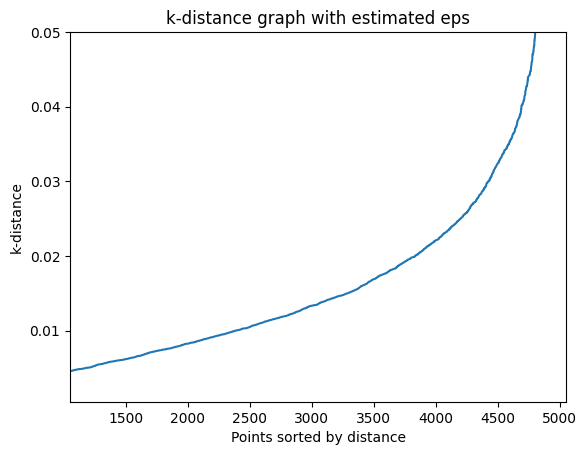

Estimated optimal eps: 0.1838642716666406


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

def find_optimal_eps(distances):
    # Calculate the slope (derivative) of the k-distance curve
    slopes = np.diff(distances) / np.diff(range(len(distances)))
    
    # Calculate the change in slope between consecutive points
    slope_changes = np.diff(slopes)
    
    # Find the index of the maximum change in slope
    elbow_index = np.argmax(slope_changes) + 1  # +1 to correct the index due to the diff reducing the array length by 1
    
    return distances[elbow_index]

# Example usage with your existing code
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(scaled_data)
distances, indices = neighbors_fit.kneighbors(scaled_data)
distances = np.sort(distances, axis=0)
distances = distances[:, 1]

# Find the optimal eps
optimal_eps = find_optimal_eps(distances)

# Plot the k-distance graph with the optimal eps marked
plt.plot(distances)
plt.axvline(x=optimal_eps, color='r', linestyle='--')
plt.xlim(1050, 5050)  # Adjust based on your dataset
plt.ylim(0.0005, 0.05)  # Adjust based on your dataset
plt.xlabel('Points sorted by distance')
plt.ylabel('k-distance')
plt.title('k-distance graph with estimated eps')
plt.show()

print("Estimated optimal eps:", optimal_eps)


In [12]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

def estimate_eps_range(data, min_samples=4):
    neighbors = NearestNeighbors(n_neighbors=min_samples)
    neighbors_fit = neighbors.fit(data)
    distances, indices = neighbors_fit.kneighbors(data)
    
    # Sort the distances
    distances = np.sort(distances, axis=0)
    distances = distances[:, -1]  # Take the distance to the furthest neighbor
    
    # Determine eps range systematically
    eps_start = np.percentile(distances, 10)  # 10th percentile
    eps_end = np.percentile(distances, 90)    # 90th percentile
    eps_interval = (eps_end - eps_start) / 20 # Divide the range into 20 intervals
    
    return eps_start, eps_end, eps_interval
if __name__ == "__main__":
    # Load and scale data
    scaled_data = load_and_preprocess_data(DATA_FILE_PATH)
    
    # Estimate eps range based on the scaled data
    eps_start, eps_end, eps_interval = estimate_eps_range(scaled_data, min_samples=4)
    
    print(f"Estimated eps range: Start = {eps_start}, End = {eps_end}, Interval = {eps_interval}")
    
    # Define your ranges for eps and min_samples based on prior analysis
    eps_values = np.arange(eps_start, eps_end + eps_interval, eps_interval)  # Adjust based on your dataset
    min_samples_values = range(2, 31)  # Adjust based on your dataset

    # Evaluate DBSCAN across parameter ranges
    dbscan_results = evaluate_dbscan_params(scaled_data, eps_values, min_samples_values)

    # Save the results for further analysis
    results_file_path = os.path.join(RESULTS_PATH, 'dbscan_tuning_results.csv')
    dbscan_results.to_csv(results_file_path, index=False)
    print(f"Results saved to {results_file_path}")
    
    # Print best parameters based on Silhouette Score
    best_params = dbscan_results.loc[dbscan_results['silhouette'].idxmax()]
    print("Best parameters based on Silhouette Score:", best_params)


Estimated eps range: Start = 0.00685210992756108, End = 0.05609796344728311, Interval = 0.0024622926759861013
Skipping (eps: 0.00685210992756108, min_samples: 19) due to a single cluster.
Skipping (eps: 0.00685210992756108, min_samples: 20) due to a single cluster.
Skipping (eps: 0.00685210992756108, min_samples: 21) due to a single cluster.
Skipping (eps: 0.00685210992756108, min_samples: 22) due to a single cluster.
Skipping (eps: 0.00685210992756108, min_samples: 23) due to a single cluster.
Skipping (eps: 0.00685210992756108, min_samples: 24) due to a single cluster.
Skipping (eps: 0.00685210992756108, min_samples: 25) due to a single cluster.
Skipping (eps: 0.00685210992756108, min_samples: 26) due to a single cluster.
Skipping (eps: 0.00685210992756108, min_samples: 27) due to a single cluster.
Skipping (eps: 0.00685210992756108, min_samples: 30) due to a single cluster.
Skipping (eps: 0.009314402603547182, min_samples: 23) due to a single cluster.
Skipping (eps: 0.00931440260354

In [13]:
def refine_eps_estimation(data, percentile_low=5, percentile_high=95, interval_divisor=50):
    neighbors = NearestNeighbors(n_neighbors=4)
    neighbors_fit = neighbors.fit(data)
    distances, _ = neighbors_fit.kneighbors(data)
    distances = np.sort(distances[:, -1])
    
    eps_start = np.percentile(distances, percentile_low)
    eps_end = np.percentile(distances, percentile_high)
    eps_interval = (eps_end - eps_start) / interval_divisor
    
    return eps_start, eps_end, eps_interval

# Adjusting min_samples selection
dimensionality = scaled_data.shape[1]  # Number of features
min_samples_start = dimensionality + 1
min_samples_end = 2 * dimensionality
print(f"Refined min_samples range: Start = {min_samples_start}, End = {min_samples_end}, Interval = 1")

# Adjusting the main execution block
if __name__ == "__main__":
    scaled_data = load_and_preprocess_data(DATA_FILE_PATH)
    
    eps_start, eps_end, eps_interval = refine_eps_estimation(scaled_data, 5, 95, 100)
    print(f"Refined eps range: Start = {eps_start}, End = {eps_end}, Interval = {eps_interval}")
    
    # min_samples_values = range(min_samples_start, min_samples_end + 1)  # Adjust based on your dataset's dimensionality
    # eps_values = np.arange(eps_start, eps_end + eps_interval, eps_interval)
    # 
    # dbscan_results = evaluate_dbscan_params(scaled_data, eps_values, min_samples_values)
    # results_file_path = os.path.join(RESULTS_PATH, 'dbscan_tuning_results.csv')
    # dbscan_results.to_csv(results_file_path, index=False)
    # print(f"Results saved to {results_file_path}")
    # 
    # if not dbscan_results.empty:
    #     best_params = dbscan_results.loc[dbscan_results['silhouette'].idxmax()]
    #     print("Best parameters based on Silhouette Score:", best_params)
    # else:
    #     print("No valid clusters formed with the given parameters.")


Refined min_samples range: Start = 3, End = 4, Interval = 1
Refined eps range: Start = 0.00442318873650975, End = 0.07713878717174705, Interval = 0.000727155984352373


In [14]:
from scipy.stats import skew, kurtosis

def dynamic_eps_parameters(data, min_samples=4):
    neighbors = NearestNeighbors(n_neighbors=min_samples)
    neighbors_fit = neighbors.fit(data)
    distances, indices = neighbors_fit.kneighbors(data)
    
    # Sort the distances
    distances = np.sort(distances, axis=0)
    distances = distances[:, -1]  # Take the distance to the furthest neighbor
    
    # Calculate skewness and kurtosis
    data_skewness = skew(distances)
    data_kurtosis = kurtosis(distances)
    
    # Adjust percentiles based on skewness and kurtosis
    # Initial conditions with broad assumptions
    lower_percentile, upper_percentile = 10, 90
    # if data_skewness > 2 or data_kurtosis > 7:  # Extremely high skewness or kurtosis
    #     lower_percentile, upper_percentile = 30, 70
    #     print("Extremely high skewness or kurtosis")
    # # Adjust percentiles based on skewness and kurtosis
    # elif data_skewness > 1 or data_kurtosis > 3:  # Very high skewness or very high kurtosis
    #     lower_percentile, upper_percentile = 20, 80
    #     print("Very high skewness or kurtosis")
    # 
    # elif 0.5 < data_skewness <= 1 or 1 < data_kurtosis <= 3:  # Moderately high skewness or kurtosis
    #     lower_percentile, upper_percentile = 15, 85
    #     print("Moderately high skewness or kurtosis")
    # 
    # elif -0.5 <= data_skewness <= 0.5 and -1 <= data_kurtosis <= 1:  # Low skewness and kurtosis (close to normal)
    #     lower_percentile, upper_percentile = 5, 95
    #     print("Low skewness and kurtosis, close to normal distribution")
    # 
    # elif data_skewness < -1 or data_kurtosis < -1:  # Very low skewness or very low kurtosis (platykurtic)
    #     lower_percentile, upper_percentile = 25, 75
    #     print("Very low skewness or very low kurtosis, data might be platykurtic")
    #     
    # elif data_skewness < -2 or data_kurtosis < -3:  
    #     # Extremely low skewness or kurtosis (indicating significant left skew or very flat distributions)
    #     lower_percentile, upper_percentile = 40, 60
    #     print("Extremely low skewness or kurtosis, significant left skew or very flat distributions")
    # 
    # else:  # For all other cases, use a default range
    #     print("Using default percentile range for eps estimation")

    print(f"Using percentiles: {lower_percentile}th to {upper_percentile}th for eps estimation.")

    
    # Determine eps range systematically
    eps_start = np.percentile(distances, lower_percentile)
    eps_end = np.percentile(distances, upper_percentile)
    
    # Adjust number of intervals based on range and variance
    eps_range = eps_end - eps_start
    intervals = int(np.ceil(eps_range / np.std(distances) * 10))  # Example adjustment
    
    return eps_start, eps_end, intervals

# Use the dynamic_eps_parameters function
eps_start, eps_end, num_intervals = dynamic_eps_parameters(scaled_data, min_samples=4)
eps_interval = (eps_end - eps_start) / num_intervals
eps_values = np.arange(eps_start, eps_end + eps_interval, eps_interval)
print(f"Refined eps range: Start = {eps_start}, End = {eps_end}, Interval = {eps_interval}")

Using percentiles: 10th to 90th for eps estimation.
Refined eps range: Start = 0.00685210992756108, End = 0.05609796344728311, Interval = 0.0024622926759861013
